In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv('../input/seedstars-dataset/Seedstars_cleaned.csv')
df_clean = pd.read_csv('../input/clean-seedstars/Seedstars_dataset_EDA_v0.csv', sep=";")


In [3]:
df_clean['age_today'] = df['Age today']
df_clean['age_today'].fillna(0,inplace=True)

In [4]:
# ['country','industry','Number of team members','number_employees','business_stage','amount_to_raise', 'funding at the time of application','Funding before Seedstars', 'Total Funding', 'FUNDED',
#        'status_of_funding_AMOUNT', 'status_of_funding_STATUS',
#        'website_active','age_today']

In [5]:
fig = px.box(df_clean, y="Total Funding")
fig.show();

In [6]:
fig = px.box(df_clean, y="status_of_funding_AMOUNT")
fig.show();

In [7]:
df_clean['status_of_funding_AMOUNT'].describe()

count    4.244000e+03
mean     1.578892e+04
std      8.932874e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.000000e+06
Name: status_of_funding_AMOUNT, dtype: float64

In [8]:
df_clean['Total Funding'].describe()

count    4.244000e+03
mean     2.714219e+05
std      2.969842e+06
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      7.430175e+04
max      1.255400e+08
Name: Total Funding, dtype: float64

In [9]:
df_clean[(df_clean['business_stage']=='Idea Stage') & (df_clean['Total Funding'] <= 74301.75)]

,Unnamed: 0,company_id,country,industry,business_stage,incorporated,incorporation_date,Number of team members,accelerator,amount_to_raise,...,revenue_model_freemium_Imputed,revenue_model_advertising_Imputed,revenue_model_licensing_Imputed,customer_type - B-to-B-to-C_Imputed,customer_type - B-to-B_Imputed,customer_type - B-to-C_Imputed,customer_type - B-to-G_Imputed,percent_increase_in_revenue,percent_increase_in_users,age_today
81,81,840,Mozambique,HighTech / NanoTech / Materials,Idea Stage,0.0,2017,4.0,0.0,0,...,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.000000,0.000000,29.0
88,88,1664,Mozambique,Health / Wellness,Idea Stage,0.0,2018,2.0,1.0,0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.0
136,136,443,Argentina,MedTech / BioTech,Idea Stage,0.0,2017,1.0,0.0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.000000,82.0
151,151,817,Argentina,Industrial / Energy / Clean Tech,Idea Stage,0.0,2017,3.0,0.0,2500,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,-36.211155,-40.039643,90.0
298,298,249,Indonesia,Health / Wellness,Idea Stage,0.0,2017,2.0,0.0,50,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,-36.585366,-14.570858,32.0
576,576,2807,Vietnam,Other,Idea Stage,0.0,2017,1.0,0.0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.000000,74.0
579,579,2947,Vietnam,Other,Idea Stage,0.0,2015,1.0,0.0,1000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,449.910018,2445.109780,25.0
833,833,163,Lebanon,Automotive,Idea Stage,0.0,2019,4.0,1.0,0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.000000,0.000000,17.0
943,943,1809,Uganda,Other,Idea Stage,1.0,2014,3.0,0.0,50000,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-49.950050,-48.745938,41.0
1006,1006,693,Ukraine,Aerospace,Idea Stage,0.0,2018,1.0,0.0,0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.000000,0.000000,32.0


In [10]:
df_clean['age_today_years'] =  df_clean['age_today'].apply(lambda row: row//12)

In [11]:
# classifying based on the 75% values of total funding
# This will be represented as 1 for the startups that were successful in raising total fundings upto to the 75% funding value and 0 for those startups that could not. 

df_clean['raised_e04'] = df_clean['Total Funding'].apply(lambda row: 1 if row>=74301.75 else 0) 

In [12]:
df_clean['raised_e04'].value_counts()

0    3183
1    1061
Name: raised_e04, dtype: int64

In [13]:
df_clean['total_size'] = df_clean['number_employees'] + df_clean['Number of team members']

In [14]:
seed = df_clean.copy()
# seed.head()
seed_y = seed['raised_e04']

In [15]:
def one_hot(dataframe, nominal):
    gen_onehot_features = pd.get_dummies(dataframe[nominal])
    result = pd.concat([dataframe, gen_onehot_features],axis=1)
    result.drop([nominal],axis=1,inplace=True)
    result.drop(result.columns[(result == 0).sum() > 0.995*result.shape[0]], axis = 1, inplace = True) 

    return result

def one_hot_market(dataframe):
    gen_onehot_features = pd.get_dummies(dataframe['market'])
    result = pd.concat([dataframe, gen_onehot_features],axis=1)
    result.drop(['market'],axis=1,inplace=True)
#     print(result.columns[(result == 0).sum() > 0.995*result.shape[0]])
    result.drop(result.columns[(result == 0).sum() > 0.995*result.shape[0]], axis = 1, inplace = True) 

    return result

def one_hot_location(dataframe):
    gen_onehot_features = pd.get_dummies(dataframe['location'])
    result = pd.concat([dataframe, gen_onehot_features],axis=1)
    result.drop(['location'],axis=1,inplace=True)
    result.drop(result.columns[(result == 0).sum() > 0.995*result.shape[0]], axis = 1, inplace = True) 

    return result

In [16]:
seed['industry'] = seed['industry'].replace(['Other'],'More') # to avoid duplicate features with reference to business stage

In [17]:
seed_x =one_hot(one_hot(seed[['number_employees','age_today_years','industry','business_stage']],"business_stage"),"industry")

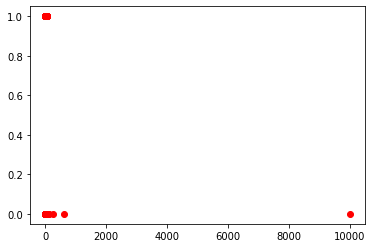

In [18]:
plt.scatter(seed_x['number_employees'], seed_y, color='red');

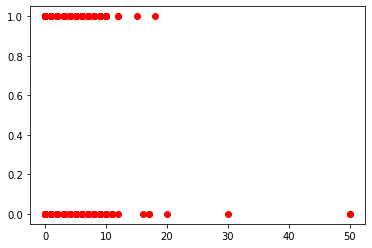

In [19]:
plt.scatter(seed_x['age_today_years'], seed_y, color='red');

In [20]:
seed_x_train, seed_x_test, seed_y_train, seed_y_test = train_test_split(seed_x, 
                                                                        seed_y, 
                                                                        test_size=0.2,
                                                                        random_state=7)

In [21]:
duplicate_columns = seed_x_train.columns[seed_x_train.columns.duplicated()]
duplicate_columns

Index([], dtype='object')

In [22]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import model_selection


xgb = XGBClassifier()
rfc = RandomForestClassifier()
knn = KNeighborsClassifier()

In [23]:
# xgb.fit(seed_x_train, seed_y_train)
# xgb.predict_proba(seed_x_train)
# xgb.score(seed_x_train, seed_y_train)

    
# y_pred_xgb = xgb.predict(seed_x_test)
# y_prob_xgb = xgb.predict_proba(seed_x_test)
    
# r_sq_xgb = xgb.score(seed_x_train, seed_y_train)
    
# scoring = 'roc_auc'
# kfold = model_selection.KFold(n_splits=10, random_state=7, shuffle=True)
# results_xgb = model_selection.cross_val_score(xgb, seed_x_train, seed_y_train, cv=kfold, scoring=scoring)
    
# matrix_xgb = confusion_matrix(seed_y_test, y_pred_xgb)
# report_xgb = classification_report(seed_y_test, y_pred_xgb);

In [24]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# seed_x_train = scaler.fit_transform(seed_x_train)
# seed_x_train

In [25]:
def model_result(x_train, x_test, y_train, y_test, model_name, model):
    model.fit(x_train, y_train)
    model.predict_proba(x_train)
    model.score(x_train, y_train)

    result = model.fit(x_train, y_train)
    result.predict(x_test)
    
    y_pred = model.predict(x_test)
    y_prob = model.predict_proba(x_test)
    
    
    
    kfold = model_selection.KFold(n_splits=10, random_state=7, shuffle=True)
    logloss = model_selection.cross_val_score(model, x_train, y_train, cv=kfold, scoring='neg_log_loss')
    auc = model_selection.cross_val_score(model, x_train, y_train, cv=kfold, scoring='roc_auc')
    
    
    matrix = confusion_matrix(y_test, y_pred)
    
    report = classification_report(y_test, y_pred)
    
    # print result
    print('\n\n')
    print('{}: '.format(model_name))
    print('Training Set Accuracy: {}%'.format(round(model.score(x_train, y_train)*100,2)))
    print('Testing Set Accuracy: {}%'.format(round(model.score(x_test, y_test)*100,2)))
    print("Log loss: %.3f (%.3f)" % (logloss.mean(), logloss.std()))
    print("AUC: %.3f (%.3f)" % (auc.mean(), auc.std()))
    print('Confusion Matrix: \n', matrix)
    print('Model Report: \n', report)
    print('\n')
    

In [26]:
models = {'XGBoost': xgb, 'Random Forest Classifier': rfc, 'KNeighbours Classifier': knn}

for key, val in models.items():
    model_result(seed_x_train, seed_x_test, seed_y_train, seed_y_test, key, val);

[15:48:59] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:49:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:49:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:49:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be